In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

In [253]:
df = pd.read_pickle('data/select-wind-power-0608-2.pkl')
print(df.columns)

Index(['index', 'Year', 'Company Name', 'EIA\nPlant ID', 'CEC\nPlant ID',
       'Plant Name', 'State', 'Capacity (MW)', 'Gross MWh', 'Net MWh',
       'mean MW', 'cap_frac', 'NumberOfUnits', 'latitude', 'longitude',
       'n_turbs', 'per_turb_power', 'per_turb_capacity', 'per_turb_cap_frac',
       'mean_wind_speed', 'mean_cubed_wind_speed', 'elevation', 'temperature',
       'pressure', 'wind_dir', 'precipitation', 'mo_length', 'humidity',
       'DNI'],
      dtype='object')


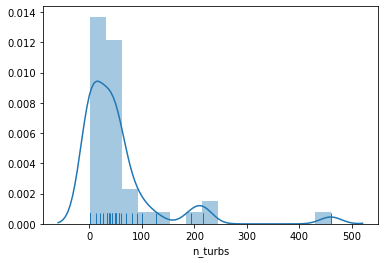

In [175]:
sns.distplot(df['n_turbs'],rug=True)

28


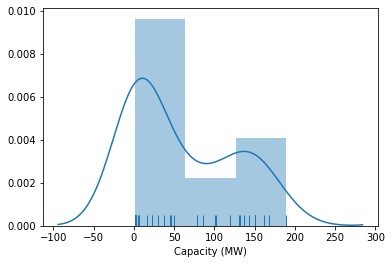

In [328]:
sns.distplot(df['Capacity (MW)'],rug=True)
is_bigfarm = (df['Capacity (MW)']>5).to_numpy()
df_bigfarms = df[is_bigfarm].reset_index() #this works for classifier
#df_bigfarms = df[df['n_turbs']>5]
print(len(df_bigfarms))

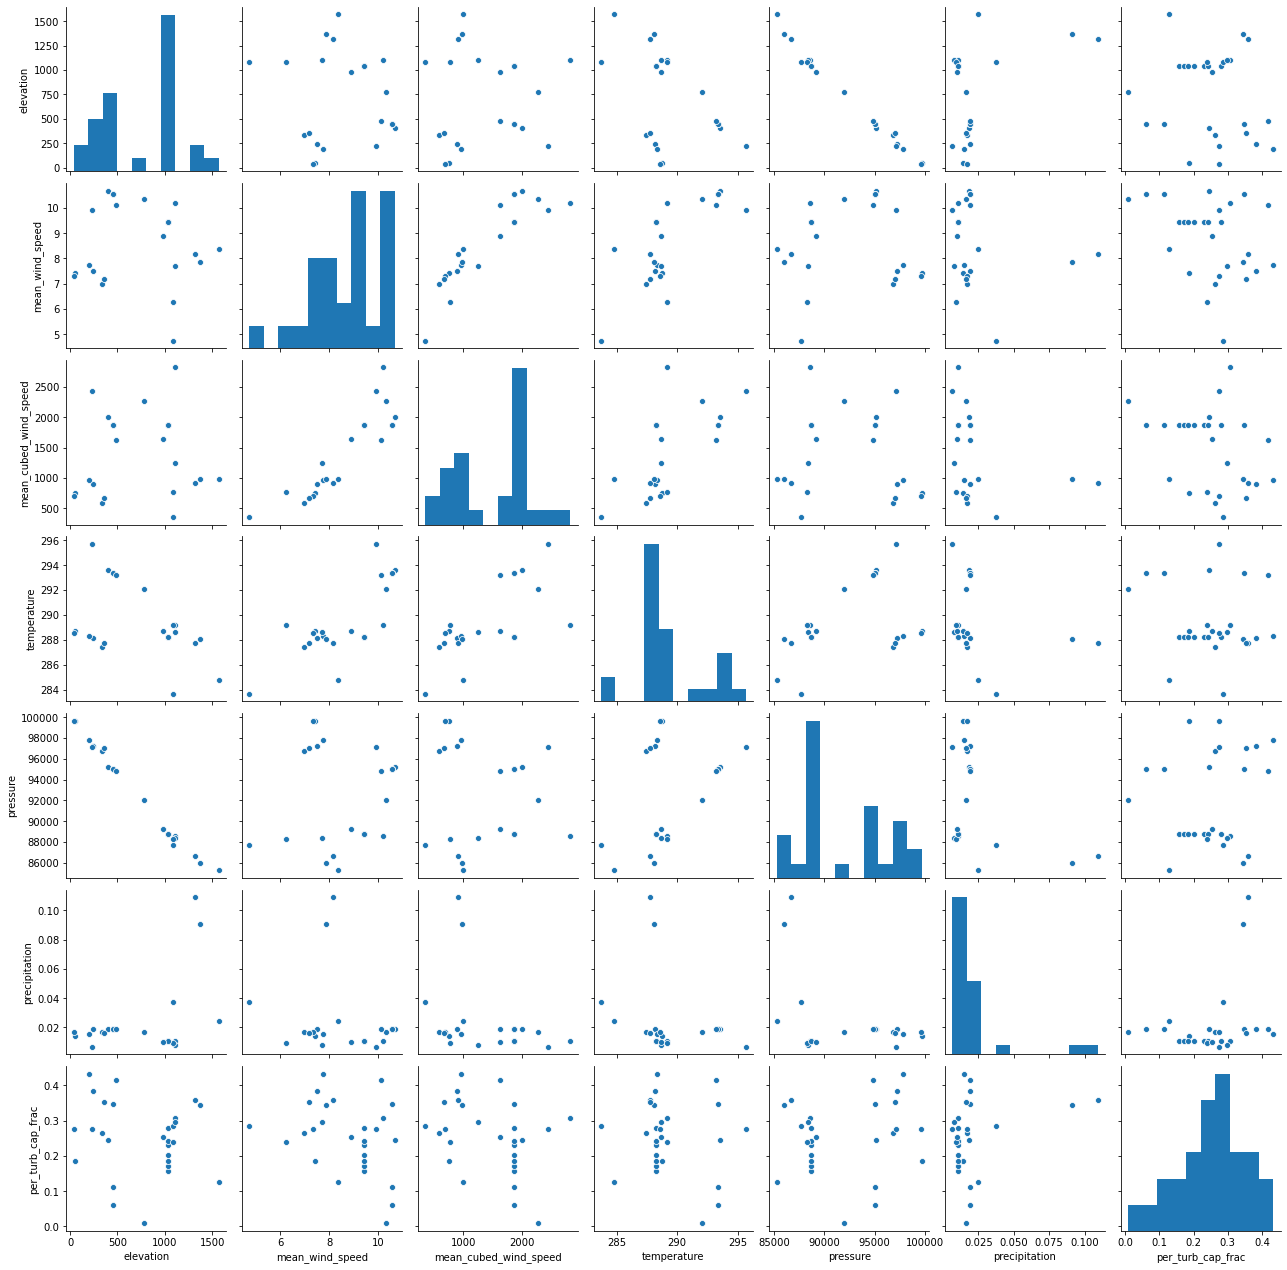

In [155]:
sns.pairplot(df_bigfarms[['elevation','mean_wind_speed','mean_cubed_wind_speed',
            'temperature','pressure','precipitation','per_turb_cap_frac']])

In [299]:
wind_speeds = np.load('data/farm_all_windspeed_80m_0607.npy')

In [264]:
wind_speeds.shape

(43, 8760)

In [86]:
365/29

12.586206896551724

In [87]:
61320/(48)

1277.5

In [74]:
365*7*24

61320

In [92]:
365/5

73.0

In [339]:
test = wind_speeds[:,:365*7*24].reshape(-1,7,5,73,24)
test_feature = (test).mean(axis=(-1,-2,1))

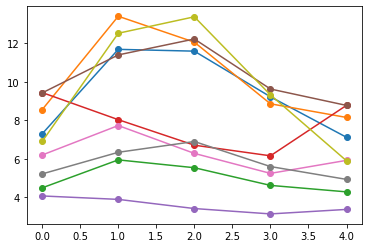

In [340]:
for i in range(0,len(df),5):
    plt.plot((test[i]).mean(axis=(-1,-2,0)),marker='o');
plt.show()
#plt.plot(test[1].reshape(-1,24*5).mean(axis=-1)); plt.show()

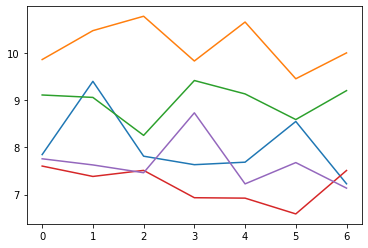

In [100]:
plt.plot(test[7].reshape(7,5,-1).mean(axis=-1))

In [195]:
df['inv_elevation'] = 1/df['elevation']

# regression

In [255]:
df.columns

Index(['index', 'Year', 'Company Name', 'EIA\nPlant ID', 'CEC\nPlant ID',
       'Plant Name', 'State', 'Capacity (MW)', 'Gross MWh', 'Net MWh',
       'mean MW', 'cap_frac', 'NumberOfUnits', 'latitude', 'longitude',
       'n_turbs', 'per_turb_power', 'per_turb_capacity', 'per_turb_cap_frac',
       'mean_wind_speed', 'mean_cubed_wind_speed', 'elevation', 'temperature',
       'pressure', 'wind_dir', 'precipitation', 'mo_length', 'humidity',
       'DNI'],
      dtype='object')

In [256]:
data = df_bigfarms
features = ['elevation','mean_wind_speed','mean_cubed_wind_speed',
            'temperature','pressure','precipitation','mo_length','humidity','wind_dir','DNI']
# X = pd.concat([
#     df[['elevation','latitude','longitude']],
#     pd.DataFrame(test_feature/np.max(test_feature))
# ],axis=1)
X = pd.concat([
    data[features],
    #pd.DataFrame(test_feature/np.max(test_feature))
],axis=1)
y = data['per_turb_cap_frac']
#y = df['per_turb_power']

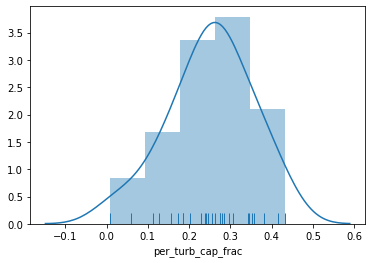

In [157]:
sns.distplot(y,rug=True)

In [178]:
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance

#test a model and print/plot testing results
def test_model(model,X,y, random_state = 0, score = 'explained_variance'):
    score_funs = {
    'explained_variance' : explained_variance_score,
    'r2' : r2_score
    }
    score_fun = score_funs[score]
    
    #split the data into training / testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= random_state)
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    #cross validate with f1 scores
    scores = cross_val_score(model,X_train,y_train,scoring = score)

    print('cross validation scores:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    #fit data and compare scores for training and testing data
    model = model.fit(X_train, y_train)
    
    print("training data")
    y_pred = model.predict(X_train)
    print(score_fun(y_train, y_pred))
    
    print("testing data")
    y_pred = model.predict(X_test)
    print(score_fun(y_test, y_pred))
    
    #plot confusion matrix and permutation importances
#     fig, (cm_ax,pi_ax) = plt.subplots(1,2,figsize=(18,5))

#     plot_confusion_matrix(model,X_test,y_test,ax=cm_ax,normalize='true')
#     cm_ax.set_title('confusion matrix')
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    
    fig.tight_layout()
    plt.show()
    
    return model #returns fitted estimator



cross validation scores: [ 0.60277427  0.37626506  0.03798249 -2.09608107 -1.36004156]
mean,std -0.48782016137329015 1.05449336065317
training data
0.7915509795432121
testing data
-0.40513683010903145


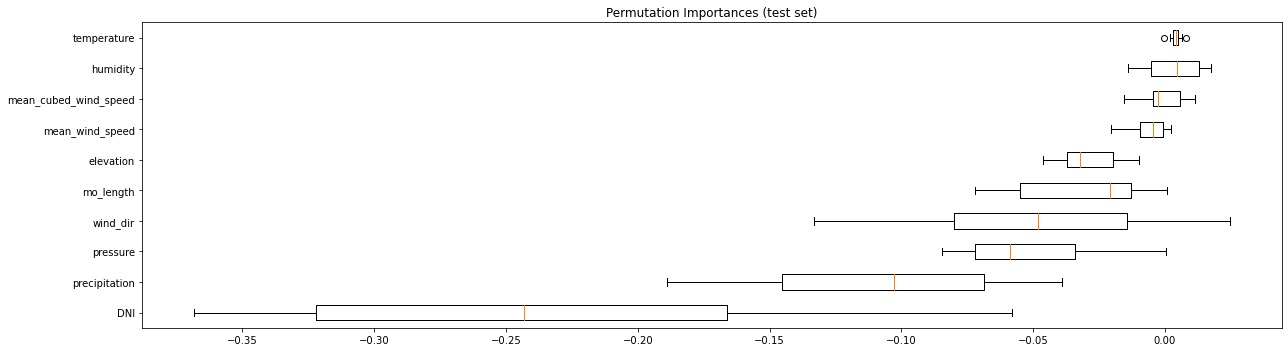

In [257]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

model = RandomForestRegressor(n_estimators=  500)
model = test_model(model,X,y,score = 'r2',random_state=0)

In [205]:
y_pred = model.predict(normalize(X))

In [180]:
import geopandas as gpd
from shapely.geometry import Point
usa_gpd = gpd.read_file('maps/states_21basic/states.shp')
ca_gpd = usa_gpd[usa_gpd.STATE_ABBR == 'CA']
# df_cat['points'] =  [Point(xy) for xy in zip(df_cat['longitude'],df_cat['latitude'])]
# crs = usa_gpd.crs
# cat_gdf = gpd.GeoDataFrame(df_cat, crs = crs, geometry = df_cat['points'])

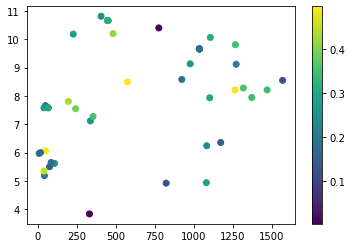

In [242]:
plt.scatter(df['elevation'],df['mean_wind_speed'], c =y);
plt.colorbar()
plt.show()

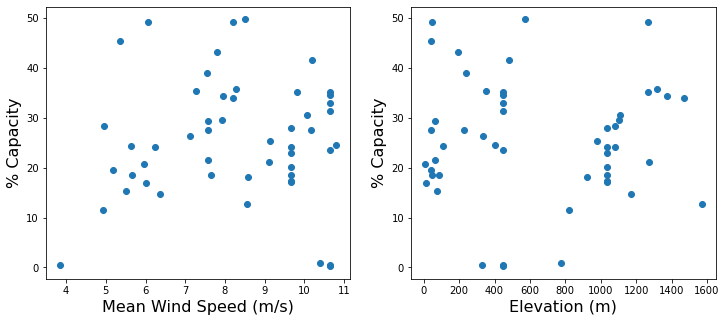

In [256]:
fig,axes = plt.subplots(1,2,figsize=(12,5))

axiter = iter(axes.ravel())
ax = next(axiter)
ax.scatter(df['mean_wind_speed'],y*100);
#ax.scatter(df['mean_wind_speed'],y_pred*100);
ax.set_ylabel('% Capacity',fontsize=16)
ax.set_xlabel('Mean Wind Speed (m/s)',fontsize=16)

# ax = next(axiter)
# ax.scatter(df['mean_cubed_wind_speed'],y*100);
# ax.scatter(df['mean_cubed_wind_speed'],y_pred*100);
# ax.set_ylabel('% Capacity',fontsize=16)
# ax.set_xlabel('Mean Wind Speed^3',fontsize=16)

ax = next(axiter)
ax.scatter(df['elevation'],y*100);
#ax.scatter(df['elevation'],y_pred*100);
ax.set_ylabel('% Capacity',fontsize=16)
ax.set_xlabel('Elevation (m)',fontsize=16)

#ax = next(axiter)
# ax.scatter(df['latitude'],y*100);
# ax.set_ylabel('% Capacity',fontsize=16)
# ax.set_xlabel('Latitude',fontsize=16)
#plt.savefig('EDA-fig-3h.png',bbox_inches='tight')
plt.show()



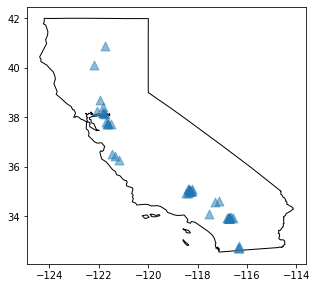

In [253]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

# ax.scatter(df['longitude'],y*100);
# ax.set_ylabel('% Capacity',fontsize=16)
# ax.set_xlabel('Longitude',fontsize=16)
base = ca_gpd.plot(color='white',edgecolor='black',ax=ax)
#ax.scatter(df['longitude'],df['latitude'],c=y*100,marker='^',s=160,alpha=0.5,cmap='coolwarm')
ax.scatter(df['longitude'],df['latitude'],marker='^',s=80,alpha=0.5)
#ax.set_ylabel('Latitude',fontsize=16)
#ax.set_xlabel('Longitude',fontsize=16)
#plt.savefig('eda-cal.png',bbox_inches='tight')
plt.show()

In [194]:
np.corrcoef(df['longitude'],y)

array([[ 1.        , -0.08123236],
       [-0.08123236,  1.        ]])

# try a classifier

In [364]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

def test_classifier(model,X,y, random_state = 0, score = 'f1'):
    score_funs = {
    'f1' : f1_score
    }
    score_fun = score_funs[score]
    
    #split the data into training / testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y, random_state= random_state)
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    #cross validate with f1 scores
    scores = cross_val_score(model,X,y,scoring = score,cv=3)

    print('cross validation scores:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    #fit data and compare scores for training and testing data
    model = model.fit(X_train, y_train)
    
    print("training data")
    y_pred = model.predict(X_train)
    print(score_fun(y_train, y_pred))
    print(classification_report(y_train,y_pred))
    print("testing data")
    y_pred = model.predict(X_test)
    print(score_fun(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    #plot confusion matrix and permutation importances
    fig, axes = plt.subplots(1,3,figsize=(18,5))
    (cm_ax,roc_ax,pi_ax) = axes.ravel()
    plot_confusion_matrix(model,X_test,y_test,ax=cm_ax,normalize='true')
    cm_ax.set_title('confusion matrix')
    plot_roc_curve(model,X_test,y_test,ax=roc_ax)
    roc_ax.plot([0,1],[0,1],c='red')
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()

    pi_ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    pi_ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
    
    plot_partial_dependence(model,X,[0,1,2,3])
    
    
    return model #returns fitted estimator

In [359]:
from sklearn.preprocessing import Binarizer
data = df_bigfarms
#features = ['elevation','latitude','longitude','mean_wind_speed','mean_cubed_wind_speed',
#            'temperature','pressure','precipitation']
# features = ['elevation','mean_wind_speed','mean_cubed_wind_speed',
#             'temperature','pressure','precipitation','mo_length','humidity','wind_dir','DNI']
# X = pd.concat([
#     df[['elevation','latitude','longitude']],
#     pd.DataFrame(test_feature/np.max(test_feature))
# ],axis=1)
X = pd.concat([
    #data[features],
    pd.DataFrame(test_feature[is_bigfarm,:])
],axis=1)
y = data['per_turb_cap_frac'].to_numpy().reshape(-1,1)
binarizer = Binarizer(threshold=0.25).fit(y)
y = binarizer.transform(y).reshape(-1)

cross validation scores: [0.33333333 0.8        0.72727273]
mean,std 0.6202020202020203 0.2050082058177352
training data
0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14

testing data
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.80      0.57      0.67         7

    accuracy                           0.71        14
   macro avg       0.73      0.71      0.71        14
weighted avg       0.73      0.71      0.71        14



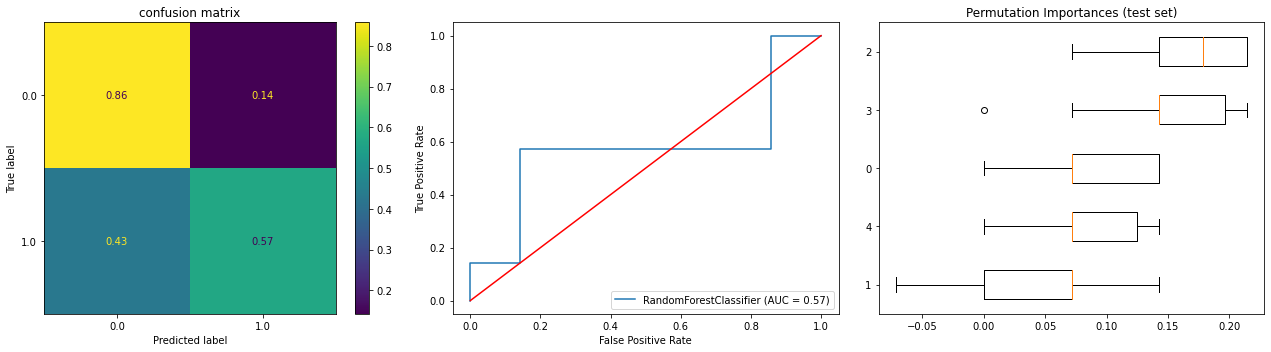

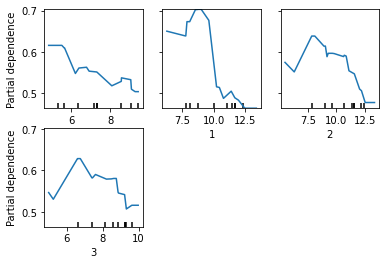

In [365]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
model = RandomForestClassifier(n_estimators=500)
#model = GaussianNB()
model = test_classifier(model,X,y,random_state=6)

# try multiclassifier

In [250]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
score_funs = {
    'f1_micro' : lambda *args: f1_score(*args,average='micro')
}
def test_multiclassifier(model,X,y, random_state = 0, score = 'f1_micro'):
    score_fun = score_funs[score]
    
    #split the data into training / testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state= random_state)
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    #cross validate with f1 scores
    scores = cross_val_score(model,X_train,y_train,scoring = score,cv = 3)

    print('cross validation scores:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    #fit data and compare scores for training and testing data
    model = model.fit(X_train, y_train)
    
    print("training data")
    y_pred = model.predict(X_train)
    print(score_fun(y_train, y_pred))
    print(classification_report(y_train,y_pred))
    print("testing data")
    y_pred = model.predict(X_test)
    print(score_fun(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    #plot confusion matrix and permutation importances
    fig, (cm_ax,roc_ax,pi_ax) = plt.subplots(1,3,figsize=(18,5))

    plot_confusion_matrix(model,X_test,y_test,ax=cm_ax,normalize='true')
    cm_ax.set_title('confusion matrix')
    #plot_roc_curve(model,X_test,y_test,ax=roc_ax)
    #roc_ax.plot([0,1],[0,1],c='red')
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()

    pi_ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    pi_ax.set_title("Permutation Importances (test set)")
    
    fig.tight_layout()
    plt.show()
    
    return model #returns fitted estimator

In [248]:
from sklearn.preprocessing import KBinsDiscretizer
data = df_bigfarms

features = ['elevation','latitude','longitude','mean_wind_speed','mean_cubed_wind_speed',
            'temperature','pressure','precipitation']
# X = pd.concat([
#     df[['elevation','latitude','longitude']],
#     pd.DataFrame(test_feature/np.max(test_feature))
# ],axis=1)
X = pd.concat([
    data[features],
    #pd.DataFrame(test_feature/np.max(test_feature))
],axis=1)
y = data['per_turb_cap_frac'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal').fit(y)
print(discretizer.bin_edges_)
y = discretizer.transform(y).reshape(-1)

[array([0.00871587, 0.22986404, 0.28478456, 0.43262684])]


cross validation scores: [0.375      0.14285714 0.28571429]
mean,std 0.26785714285714285 0.09560939526314888
training data
0.9090909090909091
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.71      0.83         7
         2.0       1.00      1.00      1.00         8

    accuracy                           0.91        22
   macro avg       0.93      0.90      0.90        22
weighted avg       0.93      0.91      0.91        22

testing data
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         2
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6



/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


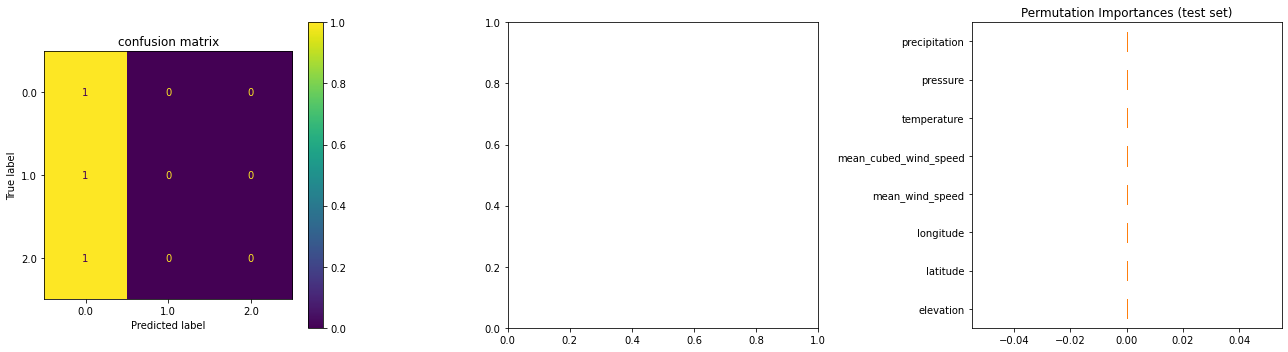

In [251]:
model = RandomForestClassifier(n_estimators=500)
model = test_multiclassifier(model,X,y)

# predict power output

In [355]:
data = df_bigfarms
# features = ['elevation','mean_wind_speed','mean_cubed_wind_speed','mo_length','humidity','DNI',
#             'temperature','pressure','precipitation','n_turbs','Capacity (MW)']
features = ['n_turbs']
# X = pd.concat([
#     df[['elevation','latitude','longitude']],
#     pd.DataFrame(test_feature/np.max(test_feature))
# ],axis=1)
X = pd.concat([
    data[features],
    pd.DataFrame(test_feature[is_bigfarm,:])
    #pd.DataFrame(test_feature/np.max(test_feature))
],axis=1)
#y = data['mean MW']
y = data['cap_frac']
#y = df['per_turb_power']

cross validation scores: [ 0.20621149 -0.5994394   0.55286955 -0.70427493 -0.23003159]
mean,std -0.15493297496183883 0.4767414579761554
training data
0.8734721796056419
testing data
0.18742746385444697


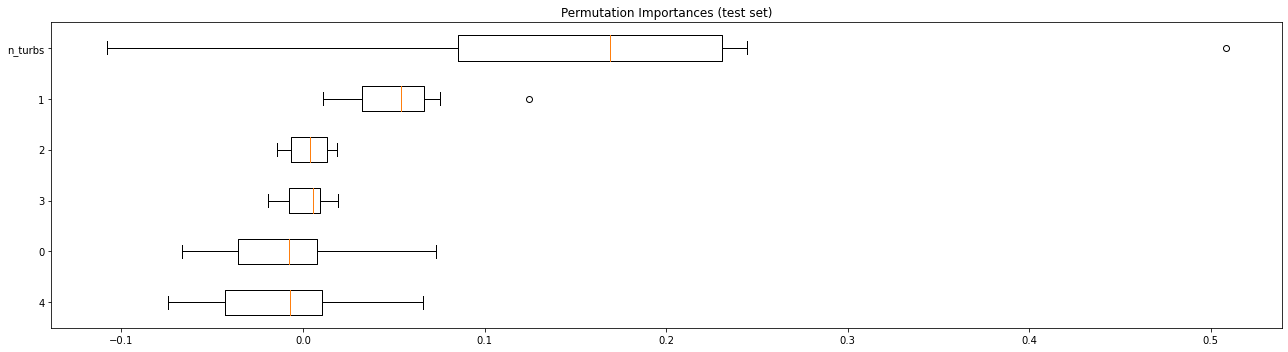

In [356]:
model = RandomForestRegressor(n_estimators=500)
model = test_model(model,X,y)

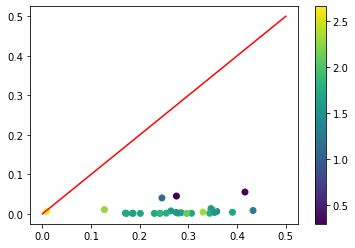

In [357]:
plt.scatter(data['cap_frac'],model.predict(X)/data['Capacity (MW)'],c = np.log10(data['n_turbs']))
plt.plot([0,0.5],[0,0.5],c='red'); plt.colorbar()

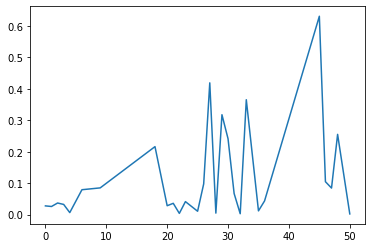

In [279]:
plt.plot(np.abs(data['cap_frac']-model.predict(X)/data['Capacity (MW)']))

In [288]:
outlier_idxs

array([23, 14, 20, 16, 26, 17,  7, 24, 13,  6, 25,  5, 18, 22, 11,  2,  9,
        3,  8,  0,  1, 21, 12,  4, 15, 10, 19, 27])

In [295]:
outlier_idxs = np.argsort((np.abs(data['cap_frac']-model.predict(X)/data['Capacity (MW)'])).to_numpy())[::-1]
data.iloc[outlier_idxs[2]]

index                                      15
Year                                     2019
Company Name             Foundation Windpower
EIA\nPlant ID                           58114
CEC\nPlant ID                           W0402
Plant Name                      Nestle Waters
State                                      CA
Capacity (MW)                             5.1
Gross MWh                               18577
Net MWh                                 18577
mean MW                               2.12149
cap_frac                             0.415979
NumberOfUnits                               2
latitude                              33.9169
longitude                             -116.75
n_turbs                                     2
per_turb_power                        1.06075
per_turb_capacity                        2.55
per_turb_cap_frac                    0.415979
mean_wind_speed                       10.1111
mean_cubed_wind_speed                 1622.32
elevation                         

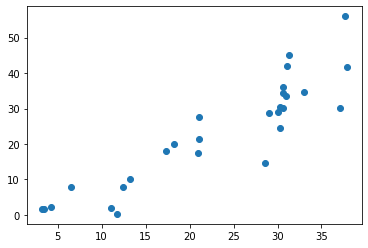

In [268]:
plt.scatter(model.predict(X),y)